### Overview

Awareness and research has helped create advances in the diagnosis and treatment of breast cancer. Due to factors such as early detection, personalized treatment & better understanding of the disease, survival rates have increased & the number of deaths is steadily declining.

![](images/bc.jpg)

I'll be using __logistic regression__ to predict the probability of a cell being cancerous or not cancerous from the features taken from breast sample images. 

### Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Data Ingestion

In [2]:
cols = "ID_number Clump_Thickness Cell_Size_Uniformity Cell_Shape_Uniformity Marginal_Adhesion Single_Epithelial_Cell_Size Bare_Nuclei Bland_Chromatin Normal_Nucleoli Mitoses Class"
cols_lst = cols.split()
filepath = "data/cancer.data"

In [3]:
bc = pd.read_csv(filepath, header=None, index_col=0, names=cols_lst)
bc.head(3)

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
ID_number,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2


### Inspecting Data

In [4]:
bc.describe()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
Clump_Thickness                699 non-null int64
Cell_Size_Uniformity           699 non-null int64
Cell_Shape_Uniformity          699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null object
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


- In pandas, objects are types that contain strings.
- Bare Nuclei is an object type indicating that it doesn't have just numeric values. This must be investigated.

In [6]:
bc['Bare_Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [7]:
bc = bc.replace('?', np.nan) 

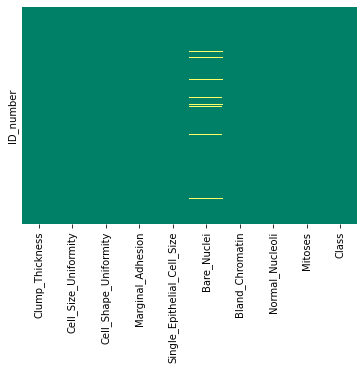

In [8]:
sns.heatmap(bc.isnull(),yticklabels=False,cbar=False,cmap='summer')
plt.show()

This heatmap reflects where missing values evaluate to 'True' in our dataset. Every yellow dash represents a missing value. 
It also serves to validate that only one column - Bare_Nuclei has missing values.

### Dealing w/ Missing Values

In [9]:
# Iterate over each column of bc
for col in bc:
    # Check if the column is of object type
    if bc[col].dtypes == 'object':
        # Impute with the most frequent value
        bc = bc.fillna(bc[col].value_counts().index[0])

bc.isnull().sum()

Clump_Thickness                0
Cell_Size_Uniformity           0
Cell_Shape_Uniformity          0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder 

le =  LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in bc:
    if bc[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        bc[col]=le.fit_transform(bc[col])

Objects have successfully been changed to integers

### Feature Selection

[This article states:](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8#:~:text=Logistic%20Regression%20is%20a%20Machine,%2C%20failure%2C%20etc.)
"Independent variables should be independent of each other. That is, the model should have little or no multicollinearity".

In [11]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

bc_mcoll = bc.drop('Class',axis=1)
#calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(bc_mcoll.values, i) for i in range(bc_mcoll.shape[1])]
vif["Predictors"] = bc_mcoll.columns

In [12]:
vif.round(2)

,VIF Factor,features
0,5.09,Clump_Thickness
1,14.01,Cell_Size_Uniformity
2,13.70,Cell_Shape_Uniformity
3,4.49,Marginal_Adhesion
4,6.83,Single_Epithelial_Cell_Size
5,1.70,Bare_Nuclei
6,7.31,Bland_Chromatin
7,4.61,Normal_Nucleoli
8,2.54,Mitoses


###### Interpretaion 
- generally a VIF above 10 indicates high correlation.
An assumption we can make is that if Cell_Size_Uniformity & Cell_Shape_Uniformity are correlated, our target is correlated as well. Cell_Size_Uniformity will be dropped.

In [14]:
corr = bc.corr()['Class']
corr

Clump_Thickness                0.716001
Cell_Size_Uniformity           0.817904
Cell_Shape_Uniformity          0.818934
Marginal_Adhesion              0.696800
Single_Epithelial_Cell_Size    0.682785
Bare_Nuclei                    0.508791
Bland_Chromatin                0.756616
Normal_Nucleoli                0.712244
Mitoses                        0.423170
Class                          1.000000
Name: Class, dtype: float64

Mitoses doesn't have as strong a relationship and will therefore not be included for modelling.

## Model Preparation

In [15]:
X = bc.drop(['Class','Mitoses', 'Cell_Size_Uniformity'] ,axis=1)
y = bc['Class']

#### Binarizing Target Variable

In [16]:
bc.Class.value_counts()

2    458
4    241
Name: Class, dtype: int64

Although 2 and 4 are numeric, we have to process them so that they're in a format our model can understand.


In [18]:
binary = {"Class": {2:0, 4:1}}
bc.replace(binary, inplace=True)

#1 MUST REP DESIRED OUTCOME

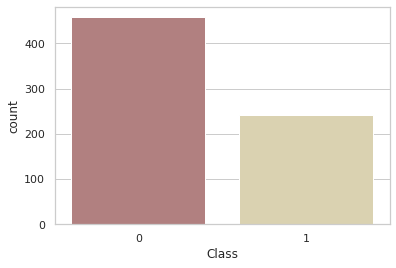

In [19]:
sns.set_style('whitegrid')
sns.countplot(x='Class',data=bc,palette='pink')
plt.show()

- Here we want to see the ratio of the target labels. 0= benign, 1= malignant
- There are more benign cells than malignant
- A way to address imbalanced classes is to oversample the minority class


In [ ]:
%matplotlib inline
pd.crosstab(bc.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

### Class imbalance
> Def: When one class is more frequent than the other.

In [ ]:
print(pd.DataFrame(y).Class.value_counts(normalize=True))

The above calculation shows that the majority class `0`constitutes $\approx 66\%$ of the observations.`1`is $\approx 34\%$.
The `smote` module from [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) deals with this problem.

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

In [ ]:
print(f'Original Dimensions: {y.shape} \n Resampled Dimensions: {y_sm.shape}')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

#### Creating Logistic Regesssion Model

In [ ]:
logmodel = LogisticRegression()

#Fit model to data
logmodel.fit(X_train,y_train)

logmodel.summary()

__The logreg now holds a logistic regression model that is fit to the data.__

### Examining Coeficients & Intercepts

In [ ]:
coef = logmodel.coef_
print(coef)

intercept = logmodel.intercept_
print(intercept)

It is interesting to have a look at the coefficients to check whether the model makes sense.

Given our fitted logistic regression model (logmodel), you can retrieve the coefficients using the attribute __coef_.__ The order in which the coefficients appear is the same as the order in which the variables were fed to the model. The intercept can be retrieved using the attribute __intercept_.__

For example, the coefficient associated with Clump Thickness is positive. This means it is positively correlated with the target.

### Predictions

In [ ]:
y_pred = logmodel.predict(X_test)
print("Accuracy of logistic regression classifier: ", logmodel.score(X_test, y_test))

Simply saying "the model has an accuracy of 96%" would be a guaranteed way to get under my manager's skin.

Accuracy tells us how often the model is right (classifies TPs correctly)/wrong. 
One should further evaluate the __performance__ of a classifier by computing a confusion matrix and generating a classification report.
By analyzing confusion matrix and classification report, one gains a better understanding of a classifier's performance. Other metrics can be calculated from a confusion matrix such as *precision*, *recall* & *F1score*

### Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion matrix of the logreg model
# print(confusion_matrix(y_test, y_pred))

In [ ]:
matrix_df = pd.DataFrame(confusion_matrix(y_pred,y_test),
                          index=['Actually Positive',  'Actually Negative'], 
                          columns=['Predicted Positive', 'Predicted Negative'])
matrix_df

In [ ]:
from sklearn.metrics import classification_report
label= ['Benign', 'Malignant']
print(classification_report(y_test, y_pred, target_names=label))

### ROC Curve

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers.
"It is nothing but a graph displaying the performance of a classification model. It is a very popular method to measure the accuracy of a classification model"

reference: https://towardsdatascience.com/roc-curve-in-machine-learning-fea29b14d133

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

logreg_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold_log = roc_curve(y_test, y_pred)

In [ ]:
plt.plot(fpr, tpr, color='black', label='ROC')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Overdispersion

Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given model.

In [ ]:
# !pip install scikitplot

In [ ]:
# import scikitplot as skplt
# import matplotlib.pyplot as plt

# y_true = probs[:,1]
# # ground truth labels
# y_probas = logreg.predict_proba(X_test)
# # predicted probabilities generated by sklearn classifier

# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()

In [ ]:
# https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, threshold = roc_curve(y_test, logmodel.predict_proba(X_test))
# roc_auc = metrics.auc(fpr, tpr)

In [ ]:
# import sklearn.metrics as metrics
# # calculate the fpr and tpr for all thresholds of the classification
# probs = logmodel.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# # roc_auc = metrics.auc(fpr, tpr)

# # method I: plt
# import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'ROC' )
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()